In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Calculate accept rate for each value condition, and also mean RT,
then run the ANOVA & paired t-tests.

note the valueH here refer to Magnitude Medium in the manuscript

Fig. S1 in the supplementary materials
"""

import os
import numpy as np
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.anova import AnovaRM
import matplotlib.pyplot as plt
import glob
from statsmodels.stats.multitest import multipletests
from scipy.stats import f_oneway

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# task conditions
task_list = ['ProbLL_valueH', 'ProbLL_valueL',
             'ProbMM_valueH', 'ProbMM_valueL',
             'ProbHH_valueH', 'ProbHH_valueL',
             'ProbMM_valueSH']

# value conditions
valueL = ['ProbLL_valueL', 'ProbMM_valueL', 'ProbHH_valueL']
valueH = ['ProbLL_valueH', 'ProbMM_valueH', 'ProbHH_valueH']
valueSH = ['ProbMM_valueSH']

# subject list
search_pattern_subj = f"{data_dir}/2*/beh/*ADMT_r1*.csv"
subj_list = sorted(glob.glob(search_pattern_subj))
subj_num = len(subj_list)

# Data structure to store results
subject_results    = {}
subject_rt_results = {}

In [ ]:
# loop through each subject
for subj_idx, subj_file in enumerate(subj_list):

    subject_folder = os.path.basename(os.path.dirname(os.path.dirname(subj_file)))

    search_pattern_beh = f"{data_dir}/{subject_folder}/beh/*ADMT_r*.csv"
    beh_list = sorted(glob.glob(search_pattern_beh))

    # Store accept rates per task condition for each value condition
    all_accept_rates_L = {task: [] for task in valueL}
    all_accept_rates_H = {task: [] for task in valueH}
    all_accept_rates_SH= {task: [] for task in valueSH}

    # Store RTs per task condition
    all_rt_L  = {task: [] for task in valueL}
    all_rt_H  = {task: [] for task in valueH}
    all_rt_SH = {task: [] for task in valueSH}

    for beh_idx, beh_file in enumerate(beh_list):
        beh_name = os.path.basename(beh_file)

        df_beh = pd.read_csv(beh_file)
        # loop through each task
        for task in valueL:
            df_task       = df_beh[df_beh['Label'] == task]
            df_task_accept= df_task[df_task['choice_key.keys'] == 1]
            accept_rate   = df_task_accept.shape[0] / df_task.shape[0]
            all_accept_rates_L[task].append(accept_rate)
            all_rt_L[task].append(np.nanmean(df_task['choice_key.rt']))

        for task in valueH:
            df_task       = df_beh[df_beh['Label'] == task]
            df_task_accept= df_task[df_task['choice_key.keys'] == 1]
            accept_rate   = df_task_accept.shape[0] / df_task.shape[0]
            all_accept_rates_H[task].append(accept_rate)
            all_rt_H[task].append(np.nanmean(df_task['choice_key.rt']))

        for task in valueSH:
            df_task       = df_beh[df_beh['Label'] == task]
            df_task_accept= df_task[df_task['choice_key.keys'] == 1]
            accept_rate   = df_task_accept.shape[0] / df_task.shape[0]
            all_accept_rates_SH[task].append(accept_rate)
            all_rt_SH[task].append(np.nanmean(df_task['choice_key.rt']))

    # Compute the mean accept rate across runs for each task condition
    mean_accept_rates_L = {task: np.nanmean(all_accept_rates_L[task])  for task in valueL}
    mean_accept_rates_H = {task: np.nanmean(all_accept_rates_H[task])  for task in valueH}
    mean_accept_rates_SH= {task: np.nanmean(all_accept_rates_SH[task]) for task in valueSH}

    # Compute the mean RT across runs for each task condition
    mean_rt_L  = {task: np.nanmean(all_rt_L[task])  for task in valueL}
    mean_rt_H  = {task: np.nanmean(all_rt_H[task])  for task in valueH}
    mean_rt_SH = {task: np.nanmean(all_rt_SH[task]) for task in valueSH}

    # Store subject‐level means
    subject_results[subject_folder]    = {
        **{t: mean_accept_rates_L[t]   for t in valueL},
        **{t: mean_accept_rates_H[t]   for t in valueH},
        **{t: mean_accept_rates_SH[t]  for t in valueSH}
    }
    subject_rt_results[subject_folder] = {
        **{t: mean_rt_L[t]     for t in valueL},
        **{t: mean_rt_H[t]     for t in valueH},
        **{t: mean_rt_SH[t]    for t in valueSH}
    }

# Convert results to DataFrames
df_results = pd.DataFrame.from_dict(subject_results,    orient="index")
df_rt      = pd.DataFrame.from_dict(subject_rt_results, orient="index")

# Compute mean and SEM across subjects
mean_accept_rates = df_results.mean()
sem_accept_rates  = df_results.sem()
mean_rt           = df_rt.mean()
sem_rt            = df_rt.sem()

In [13]:
# Extract probabilities for plotting
prob_labels = ["Low", "Medium", "High"]

# Group data for plotting Accept Rates
prob_values_L  = [mean_accept_rates[t] for t in valueL]
sem_values_L   = [sem_accept_rates[t]  for t in valueL]
prob_values_H  = [mean_accept_rates[t] for t in valueH]
sem_values_H   = [sem_accept_rates[t]  for t in valueH]
prob_value_SH  = mean_accept_rates[valueSH[0]]
sem_value_SH   = sem_accept_rates[valueSH[0]]

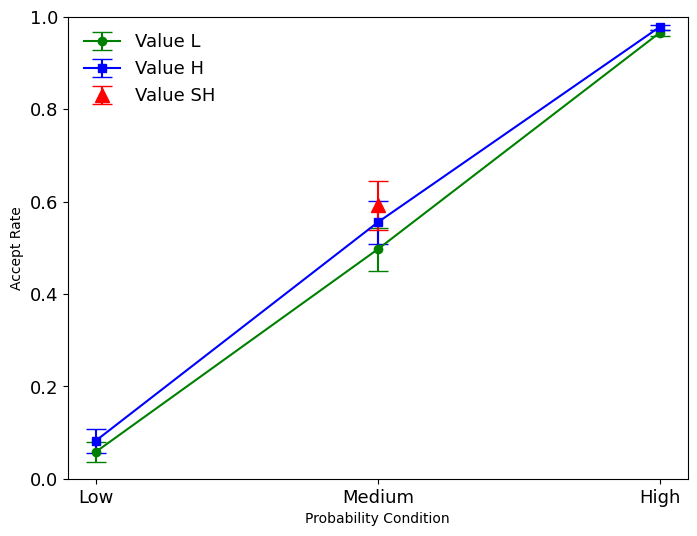

In [14]:
# Plot accept rate vs probability
plt.figure(figsize=(8, 6))
plt.errorbar(prob_labels, prob_values_L, yerr=sem_values_L,
             fmt='-o', label="Value L", capsize=7, color='green')
plt.errorbar(prob_labels, prob_values_H, yerr=sem_values_H,
             fmt='-s', label="Value H", capsize=7, color='blue')
plt.errorbar(["Medium"], [prob_value_SH], yerr=[sem_value_SH],
             fmt='^', label="Value SH", capsize=7, markersize=10, color='red')
plt.xlabel("Probability Condition")
plt.ylabel("Accept Rate")
plt.legend(fontsize=13, frameon=False)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.ylim(0,1)
plt.show()

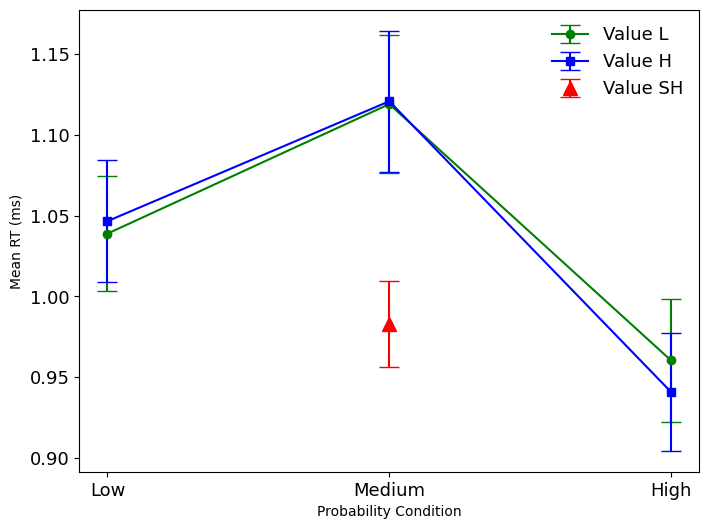

In [15]:
# Plot RT vs probability
plt.figure(figsize=(8, 6))
plt.errorbar(prob_labels, [mean_rt[t] for t in valueL],
             yerr=[sem_rt[t]  for t in valueL],
             fmt='-o', label="Value L", capsize=7, color='green')
plt.errorbar(prob_labels, [mean_rt[t] for t in valueH],
             yerr=[sem_rt[t]  for t in valueH],
             fmt='-s', label="Value H", capsize=7, color='blue')
plt.errorbar(["Medium"], [mean_rt[valueSH[0]]], yerr=[sem_rt[valueSH[0]]],
             fmt='^', label="Value SH", capsize=7, markersize=10, color='red')
plt.xlabel("Probability Condition")
plt.ylabel("Mean RT (ms)")
plt.legend(fontsize=13, frameon=False)
plt.xticks(fontsize=13); plt.yticks(fontsize=13)
plt.show()

In [ ]:
# %% compare the accept rates for the medium probability condition
low_L    = df_results["ProbLL_valueL"].dropna()
low_H    = df_results["ProbLL_valueH"].dropna()
medium_L = df_results["ProbMM_valueL"].dropna()
medium_H = df_results["ProbMM_valueH"].dropna()
medium_SH= df_results["ProbMM_valueSH"].dropna()
high_L   = df_results["ProbHH_valueL"].dropna()
high_H   = df_results["ProbHH_valueH"].dropna()

# --- Statistical Tests on Accept Rates ---
df_anova = pd.DataFrame({
    'Subject': np.repeat(np.arange(len(medium_L)), 3),
    'Condition': ['L', 'H', 'SH'] * len(medium_L),
    'Value': np.concatenate([medium_L, medium_H, medium_SH])
})
# Subject must be string
df_anova['Subject'] = df_anova['Subject'].astype(str)
aov = AnovaRM(df_anova, depvar='Value', subject='Subject', within=['Condition'])
anova_results = aov.fit()
print(anova_results)

df_low       = len(low_L)-1
t_low, p_low = stats.ttest_rel(low_L, low_H)

df_high       = len(high_L)-1
t_high, p_high= stats.ttest_rel(high_L, high_H)

p_vals_array = np.array([p_low, p_high ])  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')
print(f"Paired t-test (Low: L vs. H): t({df_low}) = {t_low:.4f}, pcorr = {p_vals_corrected[0]:.4f}")
print(f"Paired t-test (High: L vs. H): t({df_high}) = {t_high:.4f}, pcorr = {p_vals_corrected[1]:.4f}")


                 Anova
          F Value Num DF  Den DF Pr > F
---------------------------------------
Condition  0.1815 2.0000 38.0000 0.8347

Paired t-test (Low: L vs. H): t(19) = -1.4286, pcorr = 0.1693
Paired t-test (High: L vs. H): t(19) = -1.9827, pcorr = 0.1241


In [ ]:
# RT comparison
low_rt_L     = df_rt["ProbLL_valueL"].dropna()
low_rt_H     = df_rt["ProbLL_valueH"].dropna()
med_rt_L     = df_rt["ProbMM_valueL"].dropna()
med_rt_H     = df_rt["ProbMM_valueH"].dropna()
med_rt_SH    = df_rt["ProbMM_valueSH"].dropna()
high_rt_L    = df_rt["ProbHH_valueL"].dropna()
high_rt_H    = df_rt["ProbHH_valueH"].dropna()

# 1. Combine L and H within each probability level
low_rt_LH   = (low_rt_L + low_rt_H) / 2
med_rt_LH   = (med_rt_L + med_rt_H) / 2
high_rt_LH  = (high_rt_L + high_rt_H) / 2

# 2. Paired t-test: medium vs low
t_lowmed_rt, p_lowmed_rt = stats.ttest_rel(med_rt_LH, low_rt_LH)

# 3. Paired t-test: medium vs high
t_highmed_rt, p_highmed_rt = stats.ttest_rel(med_rt_LH, high_rt_LH)

# combine L and H for medium condition
med_rt_LH = (med_rt_L + med_rt_H) / 2
t_med_rt_LH, p_med_rt_LH = stats.ttest_rel(med_rt_LH, med_rt_SH)

p_vals_array = np.array([p_lowmed_rt, p_highmed_rt, p_med_rt_LH])  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')
print(f"\nPaired t-test RT (med vs. low prob, L+H): t({len(low_rt_LH)-1}) = {t_lowmed_rt:.4f}, pcorr = {p_vals_corrected[0]:.7f}")
print(f"Paired t-test RT (med vs. high prob, L+H): t({len(high_rt_LH)-1}) = {t_highmed_rt:.4f}, pcorr = {p_vals_corrected[1]}")
print(f"\nPaired t-test RT (Med: LH vs. SH): t({len(high_rt_LH)-1}) = {t_med_rt_LH:.4f}, pcorr = {p_vals_corrected[2]}")


Paired t-test RT (med vs. low prob, L+H): t(19) = 3.0305, pcorr = 0.0068806
Paired t-test RT (med vs. high prob, L+H): t(19) = 12.2431, pcorr = 5.534919527770931e-10

Paired t-test RT (Med: LH vs. SH): t(19) = 5.9105, pcorr = 1.6296237753745397e-05
